In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
BATCH_SIZE = 16
DEVICE = 'cuda:0'
EPOCHS = 10

## IMPORTING LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import timm
import os
from tqdm import tqdm
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split

## DATA LOADER CLASS

In [4]:
class LoadData(Dataset):
    
    def __init__(self, train = True):
        super().__init__()
        
        x = sorted(os.listdir('../input/overnight-hackathon/Train_Images/Train_Images'))
        
        y = []
        for i in range(len(x)):
            y.append(x[i].split('_'))
            y[i][4] = y[i][4].split('.')[0]
        
        ind = []
        size = []
        gender = []
        age = []
        
        for i in range(len(x)):
            
            x[i] = '../input/overnight-hackathon/Train_Images/Train_Images/' + x[i]
            ind.append(int(y[i][1]))
            size.append(1 if y[i][2] == 'FI' else 0)
            gender.append(1 if y[i][3] == 'M' else 0)
            age.append(int(y[i][4]))
            
        collect = list(zip(x, age, ind, gender, size))
        train_col, val_col = train_test_split(collect, shuffle = True, test_size=0.1, random_state=42)
        
        if train:
            self.image_path = [x[0] for x in train_col]
            self.age = [x[1] for x in train_col]
            self.ind = [x[2] for x in train_col]
            self.gender = [x[3] for x in train_col]
            self.size = [x[4] for x in train_col]
        
        else:
            self.image_path = [y[0] for y in val_col]
            self.age = [y[1] for y in val_col]
            self.ind = [y[2] for y in val_col]
            self.gender = [y[3] for y in val_col]
            self.size = [y[4] for y in val_col]

        
        self.transform = A.Compose([
            A.Resize(256, 256),
            A.HorizontalFlip(p = 0.5),
            A.RandomBrightnessContrast(p=0.1),
        ])
                   
    
    def __getitem__(self, idx):
        img = Image.open(self.image_path[idx])
        age = self.age[idx]
        ind = self.ind[idx]
        gender = self.gender[idx]
        size = self.size[idx]
                   
        img = np.array(img)            
        img = self.transform(image = img)['image']             
        img = (np.transpose(img, (2, 0, 1))) / 255              
        img = torch.tensor(img)
                
        return img, age, ind, gender, size
    
    def __len__(self):
        return len(self.image_path)

In [5]:
train_dataset = LoadData()
valid_dataset = LoadData(train = False)

In [6]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers = 2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers = 2,
)

#### <b> MODEL ( USED EFFIECIENT NET AND ADDED FEATURES OF GENDER AND SIZE OF THE IMAGE TO THE SECOND LAST LAYER ) </b>

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained = True, num_classes = 0)
        self.fc = nn.LazyLinear(1)
        self.dropout = nn.Dropout(p = 0.3)

    def forward(self, x, y, z):
        x = self.model(x)               
        x = self.dropout(x)
        x = torch.cat([x, y, z], dim=1) 
        x = self.fc(x)                    
        return x

In [8]:
model = Model().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## TRAIN FUNCTION

In [9]:
def train_fn(train_loader, model, criterion, optimizer):
    
    losses = []
    model.train()

    for (img, age, _, gender, size) in tqdm(train_loader, total = len(train_loader)):
        
        img = img.to(DEVICE, dtype = torch.float)
        age = age.to(DEVICE, dtype = torch.float)
        gender = gender.to(DEVICE, dtype = torch.float)
        size = size.to(DEVICE, dtype = torch.float)
        
        age = age[:, None ]
        gender = gender[:, None]
        size = size[:, None]
        
        age_pred = model(img, gender, size)
        loss = criterion(age_pred, age)

        optimizer.zero_grad()       
        loss.backward()               
        optimizer.step()              

        losses.append(loss.item())
        
    return np.mean(losses)

## VALIDATION FUNCTION

In [10]:
def valid_fn(val_loader, model, criterion):
    
    losses = []
    model.eval()

    for (img, age, _, gender, size) in tqdm(val_loader, total = len(val_loader)):
        img = img.to(DEVICE, dtype = torch.float)
        age = age.to(DEVICE, dtype = torch.float)
        gender = gender.to(DEVICE, dtype = torch.float)
        size = size.to(DEVICE, dtype = torch.float)
        
        age = age[:, None ]
        gender = gender[:, None]
        size = size[:, None]
        
        with torch.no_grad():
            age_pred = model(img, gender, size)
            loss = criterion(age_pred, age)
        
        losses.append(loss.item())
        
    return np.mean(losses)

## TRAINING OUR MODEL

In [11]:
train_losses = []
valid_losses = []

best_dict = None
best_loss = np.inf

for ep in range(EPOCHS):
    print('-'*5 + f" Epoch {ep+1} " + '-'*5)
    
    tr_loss = train_fn(train_loader, model, criterion, optimizer)
    val_loss = valid_fn(valid_loader, model, criterion)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_age_model.pt')

    train_losses.append(tr_loss)
    valid_losses.append(val_loss)
    
    print(f"Epoch {ep + 1} - Train Loss {tr_loss:.4f} - Val Loss {val_loss:.4f}\n")

----- Epoch 1 -----


100%|██████████| 185/185 [00:20<00:00,  9.14it/s]


Epoch 1 - Train Loss 140.2120 - Val Loss 97.0502

----- Epoch 2 -----


100%|██████████| 185/185 [00:18<00:00, 10.06it/s]


Epoch 2 - Train Loss 89.1122 - Val Loss 81.6219

----- Epoch 3 -----


100%|██████████| 185/185 [00:19<00:00,  9.73it/s]


Epoch 3 - Train Loss 75.2814 - Val Loss 80.0394

----- Epoch 4 -----


100%|██████████| 185/185 [00:18<00:00, 10.10it/s]


Epoch 4 - Train Loss 67.3013 - Val Loss 75.4322

----- Epoch 5 -----


100%|██████████| 185/185 [00:18<00:00,  9.93it/s]


Epoch 5 - Train Loss 60.9598 - Val Loss 67.4576

----- Epoch 6 -----


100%|██████████| 185/185 [00:19<00:00,  9.64it/s]


Epoch 6 - Train Loss 56.2409 - Val Loss 68.1414

----- Epoch 7 -----


100%|██████████| 185/185 [00:18<00:00, 10.26it/s]


Epoch 7 - Train Loss 50.3942 - Val Loss 63.8512

----- Epoch 8 -----


100%|██████████| 185/185 [00:18<00:00,  9.76it/s]


Epoch 8 - Train Loss 45.9384 - Val Loss 85.0016

----- Epoch 9 -----


100%|██████████| 185/185 [00:18<00:00,  9.87it/s]


Epoch 9 - Train Loss 42.4884 - Val Loss 65.2510

----- Epoch 10 -----


100%|██████████| 185/185 [00:18<00:00, 10.18it/s]

Epoch 10 - Train Loss 39.2166 - Val Loss 68.8680



## TRAINING AND VALIDATION LOSS CURVE

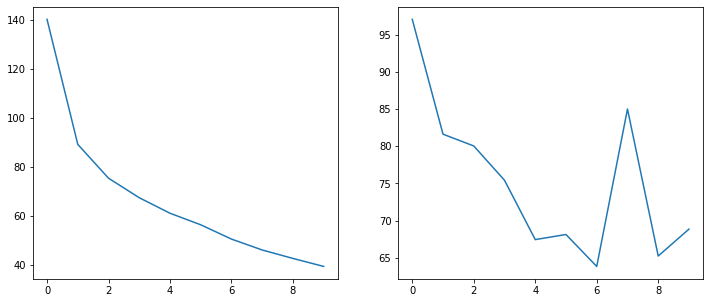

In [12]:
fig = plt.figure(figsize = (12, 5))
fig.add_subplot(1,2,1)
plt.plot(train_losses)
fig.add_subplot(1,2,2)
plt.plot(valid_losses)

In [13]:
model.load_state_dict(torch.load('./best_age_model.pt'))

<All keys matched successfully>

## DATA LOADER FOR TESTING DATA

In [14]:
class TestLoader(Dataset):
    def __init__(self, train = True):
        super().__init__()
        
        x = sorted(os.listdir('../input/overnight-hackathon/Test_Image/Test_Image'))
        y = []
        for i in range(len(x)):
            y.append(x[i].split('_'))
            y[i][3] = y[i][3].split('.')[0]
        
        self.image_path = []
        self.ind = []
        self.size = []
        self.gender = []
                   
        for i in range(len(x)):
            
            self.image_path.append('../input/overnight-hackathon/Test_Image/Test_Image/' + x[i])
            self.ind.append(int(y[i][1]))
            self.size.append(1 if y[i][2] == 'FI' else 0)
            self.gender.append(1 if y[i][3] == 'M' else 0)
                       
        self.transform = A.Compose([
            A.Resize(256, 256),
        ])
                       
    def __getitem__(self, idx):
        img = Image.open(self.image_path[idx])
        ind = self.ind[idx]
        gender = self.gender[idx]
        size = self.size[idx]
                   
        img = np.array(img)            
        img = self.transform(image = img)['image']             
        img = (np.transpose(img, (2, 0, 1))) / 255              
        img = torch.tensor(img)
                
        return img, ind, gender, size
    
    def __len__(self):
        return len(self.image_path)

In [15]:
test_dataset = TestLoader()
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 2)
model.eval()
preds = {"img_file":[], "age":[]}
bar = tqdm(enumerate(test_loader), total=len(test_loader))

with torch.no_grad():
    for idx, (img, _, gender, size) in bar:
        img = img.to(DEVICE, dtype = torch.float)
        gender = gender.to(DEVICE, dtype = torch.float)
        size = size.to(DEVICE, dtype = torch.float)
        
        gender = gender[:, None]
        size = size[:, None]
        
        age_pred = model(img, gender, size)
        preds['age'].append(age_pred.detach().cpu().numpy())

100%|██████████| 791/791 [01:23<00:00,  9.47it/s]


#### MAKING CSV FOR FINAL SUBMISSION

In [16]:
preds['age'] = np.concatenate(preds['age'])[:,0]
preds['img_file'] = sorted(os.listdir('../input/overnight-hackathon/Test_Image/Test_Image'))

In [17]:
sample = pd.DataFrame(preds)
sample.head()

,img_file,age
0,IMG_10000_HI_M.jpg,31.682896
1,IMG_10001_FI_F.jpg,33.632484
2,IMG_10002_FI_F.jpg,31.629808
3,IMG_10003_FI_F.jpg,33.424835
4,IMG_10004_FI_M.jpeg,30.311235


In [18]:
sample.to_csv("submission.csv", index = False)